# **Steps to take before running**

Files and paths: 

1. Open files, create '**data**' folder and '**county_district**' folder
2. Add [Lyme Disease Surveillance Data's](https://www.cdc.gov/lyme/stats/survfaq.html) 'County-level Lyme disease data from 2000-2019' file to '**data**' folder

****According to [CDC](https://www.cdc.gov/lyme/stats/humancases.html), estimated cases may be significantly larger***

3. Add all files in zip folders content (unzipped, without folders: all raw individual files from 2013-2019 in county folder) of [Congressional District and County Shapefiles](https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.2018.html) for 2013-2019 to '**county_district**' folder. 

Example screenshot of '**county_district**' folder content: 

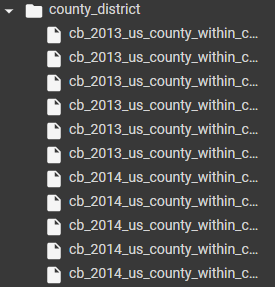

4. Choose visualization to output in selections below (type of map, year count, etc.)

***To comment out code, place a '#' the very front of the line you want to comment out, remove a '#' from the front of the line if you want to un-comment***


### Installing packages

***Optional: Uncomment first block of code below for installing packages- only need to run on first run, rest of runs can have the first block commented out again***

In [17]:
# %pip install geopandas
# %pip install folium matplotlib mapclassify


# importing necessary packages
import csv
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import pandas as pd

from matplotlib.colors import Normalize

In [18]:
#@markdown ### Load in Lyme Disease Data
#@markdown The (hidden) code in this cell loads in data uploaded to 'data' folder
#@markdown
#@markdown Double-click this text to reveal the code for editing.

# read in Lyme data 
df_raw = pd.read_csv('/content/data/LD_Case_Counts_by_County_00_19.csv', encoding = 'ISO-8859-1')

# convert state and county codes to integers
df_int_raw = df_raw.astype({'STCODE': int, 'CTYCODE' : int})

In [19]:
#@markdown ### Creating Variables/Global Variables
#@markdown The (hidden) code in this cell creates variables from Lyme disease dataset and global variable for congressional district coding
#@markdown
#@markdown Double-click this text to reveal the code for editing (especially adding in year to n-th congressional district). 

# get list versions of state names and FIPS columns
name_state = np.unique(df_int_raw.Stname.values.tolist())
fips_state = np.unique(df_int_raw.STCODE.values.tolist())

# create dictionary to covert from state name to FIPS code, vice versa
# citation: https://stackoverflow.com/questions/17426292/how-to-create-a-dictionary-of-two-pandas-dataframe-columns
state_to_code = dict(zip(name_state, fips_state))
code_to_state = dict(zip(fips_state, name_state))

# dictionary connecting the year to the congressional district map 
# update as more data becomes available
year_congress_dict = {
  2013: '113',
  2014: '114',
  2015: '114',
  2016: '115',
  2017: '115',
  2018: '116',
  2019: '116'
}


In [38]:
#@markdown ## Select Map Type

# different markdown interactive enablers to set map types

#@markdown ***Double-click this text to edit how many approaches there are for splitting and for county 999 splitting***

#@markdown Year:
selected_year = 2017 #@param {type: 'slider', min: 2013, max: 2019, step:1}
year_count = 'Cases' + str(selected_year)
year = selected_year

#@markdown Type of splitting county counts approach:
#@markdown (Only Approach 1 is available at this time)
split = 'approach_1' #@param ['approach_1', 'average']

#@markdown Include county 999 counts:
county_999 = 'no' #@param ['yes', 'no']

#@markdown IF 'yes' to last question (county 999), which approach:
county_999_split = 'approach_1' #@param ['approach_1', 'approach_2', 'average']

#@markdown State-level or national-level map:
level = 'state' #@param ['state', 'national']

#@markdown IF 'state-level' to last question, state name:
state_name = 'Maryland' #@param ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']
state = state_name
state_code = state_to_code.get(state_name)

#@markdown Tyoe of map:
type_map = 'interactive' #@param ['interactive', 'static']

#@markdown Type of count reporting (individual cases vs per 100,000):
count_report = 'per_100000' #@param ['individual', 'per_100000']

#@markdown Save file to Colab files:
save_as = 'no' #@param ['yes', 'no']


# number of different approaches for average of approaches
num_approaches = 1

num_999_approaches = 2

In [45]:
#@markdown ### Load in and reformat Congressional District and County Shapefiles
#@markdown The (hidden) code in this cell creates variables from Lyme disease dataset and global variable for congressional district coding
#@markdown
#@markdown Double-click this text to reveal the code 

# import shapefile for plotting
initial_path = '/content/county_district' # upload county shapefiles into county folder; separate into years if desired
full_path = initial_path + '/cb_' + str(year) + '_us_county_within_cd' + year_congress_dict.get(year) + '_500k.shp' 
# follows file naming style of US Census Bureau

df_gis_locations_raw = gpd.read_file(full_path)

# rename CD code to universal name
df_gis_locations_rename = df_gis_locations_raw.rename(columns = {df_gis_locations_raw.columns[2]: 'CDFP'})

# convert area codes to integer type
df_gis_locations_int = df_gis_locations_rename.astype({'STATEFP': int, 'COUNTYFP': int, 'CDFP': int})

# copy raw 
df_gis_locations = df_gis_locations_int.copy()

# remove vergin islands, etc. from plotting data
df_gis_locations = df_gis_locations.query('STATEFP <= 56')

In [46]:
#@markdown ### Convert Polygon to Area 
#@markdown
#@markdown Double-click this text to reveal the code 

# get area type of shapes
gdf = df_gis_locations['geometry'].to_crs({'proj':'cea'}) 
# convert from square feet
gis_locations_area = gdf.area / 10**6
# add area column to plotting df
df_gis_locations['AREA'] = gis_locations_area

In [47]:
#@markdown ### Approaches for Splitting Data
#@markdown
#@markdown Double-click this text to reveal the code and add more splitting approaches


# Approach 1
# function to split up the county data by area percentage 
def split_county_count_1(df_map, df_raw):
  df = df_map.copy()
  df['COUNT'] = 0.0
  # for every county/sub-county area
  for i in range(df_raw.shape[0]):
    index_df = df.loc[(df.STATEFP == df_raw['STCODE'].iloc[i]) & (df.COUNTYFP == df_raw['CTYCODE'].iloc[i])]
    indexes = index_df.index
    total = index_df['AREA'].sum() #total area of county
    # has condition of county being split up into several CD
    if len(indexes) > 1:
      for ind in indexes:
        df.at[ind, 'COUNT'] = df_raw[year_count].iloc[i] * (df.at[ind, 'AREA'] / total)
    # not split up to several CD
    elif len(indexes) > 0:
      df.at[indexes[0], 'COUNT'] = df_raw[year_count].iloc[i]
  return df

df_count_split = gpd.GeoDataFrame()
count_avg = []

# run approach_1
if split == 'approach_1' or split == 'average':
  # run function above
  df_count_split = split_county_count_1(df_gis_locations, df_int_raw)
  if split == 'average':
    count_avg = df_count_split.COUNT / num_approaches


# ADD IN MORE FUCTIONS HERE: 

# Example- 

# write function
# # run approach_2
# if split == 'approach_2' or split == 'average':
#   # run function above
#   df_count_split = split_county_count_2(df_gis_locations, df_int_raw)
#   if split == 'average':
#     count_avg = count_avg + df_count_split.COUNT / num_approaches

if split == 'average':
  df_count_split.COUNT = count_avg

# add up all the counts for each congressional district area
# citation 1st line: https://stackoverflow.com/questions/40139184/keeping-key-column-when-using-groupby-with-transform-in-pandas
df_count_split['Count'] = df_count_split.groupby(['STATEFP', 'CDFP'])['COUNT'].transform('sum')
df_congress_count = df_count_split.groupby(['STATEFP', 'CDFP']).mean()
df_congress_count = df_congress_count.drop(columns = ['COUNT'])
df_congress_count = df_congress_count.reset_index()
df_congress_count = df_congress_count.rename(columns = {'Count': 'COUNT'})

In [63]:
#@markdown ### Combining Areas and Counts for Final Plot
#@markdown
#@markdown Double-click this text to reveal the code and add more splitting of county 999 cases approaches

# function to add county 999 counts to CD counts (all approaches)
def add_county_999(df_count, count_new, df_raw_999, i):
  count_999 = 0
  df_count_999 = df_raw_999.loc[df_raw_999['CTYCODE'] == 999]
  count_final = count_new
  current_state = df_count['STATEFP'].iloc[i]

  # so long as state has a 999 county, if not, return original count_new
  if df_count_999[df_count_999['STCODE'] == current_state].shape[0] != 0:
    count_999 = df_count_999[df_count_999['STCODE'] == current_state]
    count_999 = count_999[year_count].values[0]
    # run approach_1 or mean of all 999 splitting
    if county_999_split == 'approach_1' or county_999_split == 'average':
      num_unique_cd = df_count.loc[df_count.STATEFP == current_state].shape[0] 
      count_final = count_new + (count_999 / num_unique_cd)
      if county_999_split == 'average':
        count_final = count_final / num_999_approaches
    # run approach_2 or mean of all 999 splitting
    elif county_999_split == 'approach_2' or county_999_split == 'average': 
      # citation: https://stackoverflow.com/questions/40139184/keeping-key-column-when-using-groupby-with-transform-in-pandas
      # to get total state counts for current state
      df_count['Count'] = df_count.groupby(['STATEFP'])['COUNT'].transform('sum')
      df_total_count = df_count.drop(columns = ['COUNT'])
      df_total_count = df_total_count.rename(columns = {'Count': 'COUNT'})
      df_filtered_total_count = df_total_count.loc[df_total_count['STATEFP'] == current_state]
      total_count = df_filtered_total_count.iloc[0]['COUNT']
      # catches condition of dividing by 0 below
      if total_count == 0:
        count_temp = count_new
      else:
        count_temp = count_new + count_999 * (count_new / total_count) # if 999 count is 0, then this will break (cannot divide by 0)
      # add to average count from approach_1
      if county_999_split == 'average':
        count_final = count_temp / num_999_approaches + count_final
      else:
        count_final = count_temp
    # add-in more approaches in similar format to approach_2 above as needed
      
  return count_final

# function to combine areas into one congressional district area & add counts above
def county_to_congress_map(df_map, df_count):
  df_final = gpd.GeoDataFrame(columns=['STATEFP', 'CDFP', 'geometry', 'COUNT'], geometry='geometry') 

  # for each area/sub area, group together district individually and combine geographical area and cases for final CD area and total cases
  for i in range(df_count.shape[0]):
    index_df = df_map.loc[(df_map.STATEFP == df_count['STATEFP'].iloc[i]) & (df_map.CDFP == df_count['CDFP'].iloc[i])]
    boundary = index_df.dissolve().explode(index_parts = True) 
    count_new = df_count_split.loc[(df_count_split.STATEFP == df_count['STATEFP'].iloc[i]) & (df_count_split.CDFP == df_count['CDFP'].iloc[i])].COUNT.sum()

    # add in county 999 if indicated (function above)
    if county_999  == 'yes':
      count_new = add_county_999(df_count, count_new, df_int_raw, i)

    boundary_drop = ''
    # addressing differences in columns included in US Census .zip shapefiles
    if 'ALAND' in df_map:
      boundary_drop = boundary.drop(columns = ['COUNTYFP', 'AFFGEOID', 'GEOID', 'ALAND', 'PARTFLG', 'AREA'])
    else: 
      boundary_drop = boundary.drop(columns = ['COUNTYFP', 'AFFGEOID', 'GEOID', 'PARTFLG', 'AREA'])
    boundary_count = boundary_drop.assign(COUNT = count_new)
    df_final = gpd.GeoDataFrame(pd.concat([df_final, boundary_count], ignore_index = True), crs = [df_final, boundary_count][0].crs)
  return df_final

df_map_congressional_final = county_to_congress_map(df_gis_locations, df_congress_count) 

In [67]:
#@markdown ### Reformatting for Plotting
#@markdown
#@markdown Double-click this text to reveal the code 

final_plot = gpd.GeoDataFrame()

# filter state-level if True
if level == 'state':
  final_plot = df_map_congressional_final[df_map_congressional_final['STATEFP'] == state_code]
else: 
  final_plot = df_map_congressional_final

replace = final_plot.copy()
# filter count if reporting per 100,000 people 
if count_report == 'per_100000':
  # citation: https://pandas.pydata.org/pandas-docs/version/0.22/indexing.html
  replace.loc[:, 'COUNT'] =  final_plot.loc[:, 'COUNT'].apply(lambda x: round((x / 761179) * 100000, 2))
else:
  replace.loc[:, 'COUNT'] = round(final_plot.COUNT, 2)

final_plot = replace 

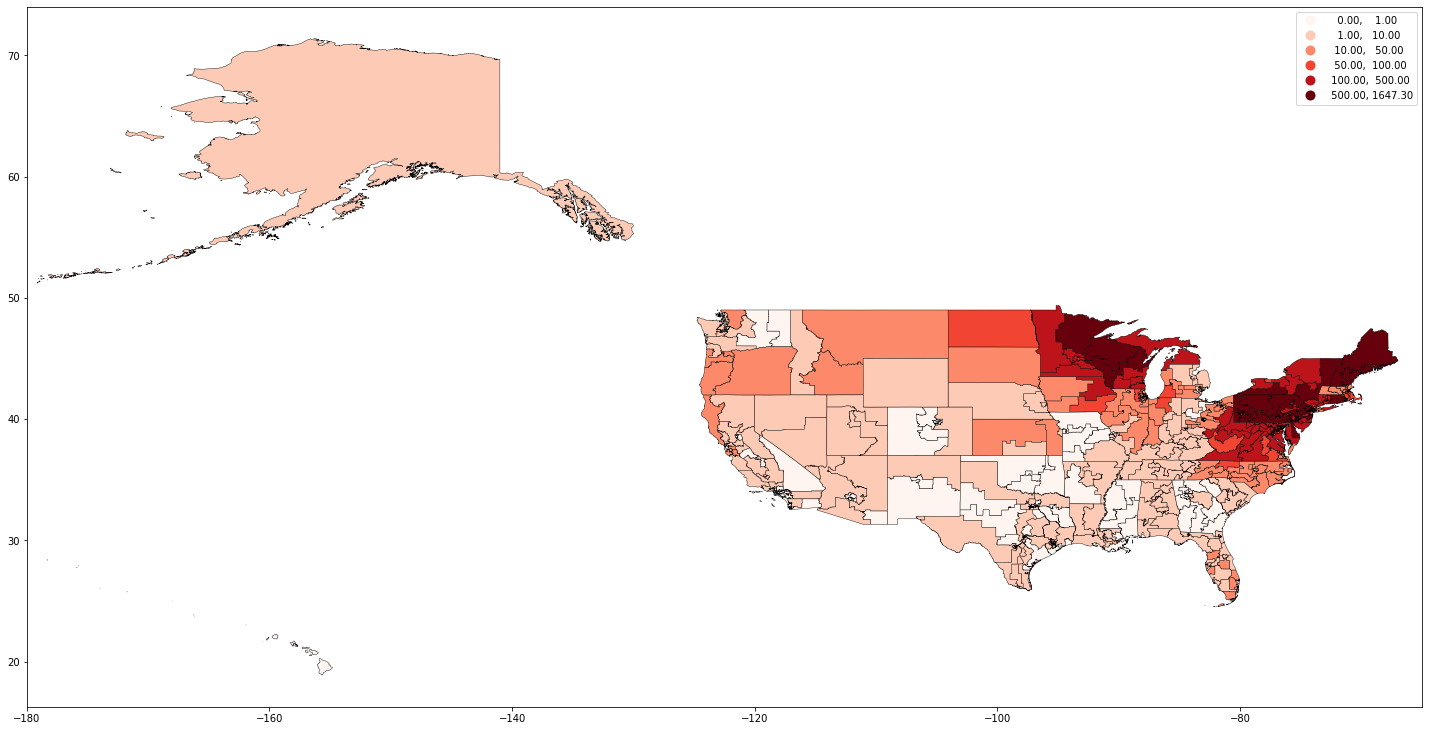

In [15]:
#@markdown ### Final Plot (static plots)
#@markdown
#@markdown Double-click this text to reveal the code 
#@markdown 
#@markdown ***(-inf in plot legend is equivilant to 0, there is no COUNT that is actually -inf in the final case counts)***


# print out graph if static type
if type_map == 'static':
  # remind user of reporting type (difference in count in legend)
  bins = [1, 10, 100, 500]
  if count_report == 'per_100000':
    print('Plotting per 100,000 people')
    bins = [1, 5, 10, 50]
  # plot map 
  fig, ax = plt.subplots(1, figsize = (25,25))
  # citation: https://stackoverflow.com/questions/56690524/matplotlib-geopandas-plot-chloropleth-with-set-bins-for-colorscheme
  # citation: https://stackoverflow.com/questions/65415390/geopandas-consistent-user-defined-color-scheme-for-subplots
  bins = [1, 10, 50, 100, 500]
  final_plot.plot(column = 'COUNT', 
                  cmap ='Reds', 
                  linewidth = 0.4, 
                  scheme="User_Defined", 
                  legend = True,
                  classification_kwds=dict(bins = bins),
                  ax = ax, 
                  edgecolor ='black',
                  norm = Normalize(0, 5), 
                  vmin = 0
  ) 
  if level == 'national':
    ax.set_xlim(-180, -65)

  # if user wanted to save file in Colab files: can download 
  if save_as == 'yes':
    if level == 'state':
      plt.savefig(str(year) + '_' + str(state) + '.png')
    else: 
      plt.savefig(str(year) + '.png')

  plt.show()

In [68]:
#@markdown ### Final Plot Cont. (Interactive plots)
#@markdown
#@markdown Double-click this text to reveal the code 
#@markdown 
#@markdown ***(-inf in plot legend is equivilant to 0, there is no COUNT that is actually -inf in the final case counts)***

final_plot_inter = gpd.GeoDataFrame()

# print out graph if interactive type
if type_map == 'interactive': 
  # update state code to name (better user understanding)
  final_copy = final_plot.copy()
  final_copy.columns = ['State', 'Congressional District', 'geometry', 'Count']
  list_state_code = list(final_plot['STATEFP'].tolist())
  add_state = [code_to_state.get(i) for i in list_state_code]
  final_copy['State'] = add_state
  final_plot = final_copy
  # remind user of reporting type 
  bins = [1, 10, 100, 500]
  if count_report == 'per_100000':
    print('Plotting per 100,000 people')
    bins = [1, 5, 10, 50]
  
  # plot map 
  # citation: https://geopandas.org/en/stable/docs/user_guide/interactive_mapping.html
  # citation: https://stackoverflow.com/questions/56690524/matplotlib-geopandas-plot-chloropleth-with-set-bins-for-colorscheme
  # citation: https://stackoverflow.com/questions/65415390/geopandas-consistent-user-defined-color-scheme-for-subplots
  final_plot_inter = final_plot.explore(
    column ='Count', # make choropleth based on 'Count' column
    tiles = 'CartoDB positron',
    cmap ='Reds',
    legend = True,
    scheme="User_Defined", 
    classification_kwds = dict(bins = bins),
    legend_kwds = dict(colorbar = False),
    style_kwds = dict(color ='black'), # black outline
    vmin = 0
  )
  
  # if user wanted to save file in Colab files: can download 
  if save_as == 'yes':
    if level == 'state':
      final_plot_inter.save(str(year) + '_' + str(state) + '.html')
    else:
      final_plot_inter.save(str(year) + '.html')

final_plot_inter 

Plotting per 100,000 people
